Привет!

Для проекта по науке о данных я поскрейпил вакансии с Хабр.Карьеры и проанализировал полученные данные, с использованием (почти) всех технологий, которые мы брали за этот семестр.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import requests
import plotly.graph_objects as go
import numpy as np
import sqlite3
import ast
import re
import lightgbm as lgb
import optuna
from geopy.geocoders import Nominatim
import folium
import networkx as nx
from itertools import combinations
from collections import Counter
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
import seaborn as sns
from plotly.subplots import make_subplots
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('vacancies.csv')
df.head(5)

Unnamed: 0                                 name        salary  \
0           0        Golang-разработчик в 2GIS.KIT           NaN   
1           1                System Analyst (OSMP)           NaN   
2           2           Fullstack QA engineer (C#)  от 200 000 ₽   
3           3  Инженер-аналитик L2 мониторинга SOC           NaN   
4           4  Инженер-аналитик L2 мониторинга SOC           NaN   

                   company                                         additional  \
0                     2GIS  ['Москва', 'Полный рабочий день', 'Можно удале...   
1  Лаборатория Касперского                                 ['Можно удаленно']   
2               Альфа-Банк  ['Москва', 'Санкт-Петербург', 'Екатеринбург', ...   
3                  Бастион  ['Красноярск', 'Новосибирск', 'Тюмень', 'Полны...   
4                  Бастион  ['Владивосток', 'Находка', 'Уссурийск', 'Полны...   

                                              skills    date  
0  ['Бэкенд разработчик', 'Средний (Middle)', 'Go...  5 июня  
1  ['Системный аналитик', 'Бизнес аналитика', 'Си...  5 июня  
2  ['Инженер по автоматизации тестирования', 'Сре...  5 июня  
3  ['Инженер по безопасности', 'Средний (Middle)'...  5 июня  
4  ['Инженер по безопасности', 'Средний (Middle)'...  5 июня

In [3]:
df = df.drop('Unnamed: 0', axis = 1)
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        3146 non-null   object
 1   salary      627 non-null    object
 2   company     3146 non-null   object
 3   additional  3146 non-null   object
 4   skills      3146 non-null   object
 5   date        3146 non-null   object
dtypes: object(6)
memory usage: 147.6+ KB
None


name        salary          company  \
count                 3146           627             3146   
unique                2492           250              595   
top     Системный аналитик  от 200 000 ₽  Bell Integrator   
freq                    70            28              285   

                                       additional  \
count                                        3146   
unique                                        419   
top     ['Полный рабочий день', 'Можно удаленно']   
freq                                          760   

                                                   skills    date  
count                                                3146    3146  
unique                                               2858      32  
top     ['Программист 1С', 'Средний (Middle)', 'Разраб...  30 мая  
freq                                                   17     420

In [4]:
df.isna().sum()

name             0
salary        2519
company          0
additional       0
skills           0
date             0
dtype: int64

# Обработка данных

Для начала почистим данные. Заменим строки списками, которыми они являются

In [5]:
df['additional'] = df['additional'].apply(ast.literal_eval)
df['skills'] = df['skills'].apply(ast.literal_eval)

Посмотрим на формат указанных зарплат

In [6]:
print(df['salary'][df['salary'].notna()])

2                  от 200 000 ₽
6                     от 1000 $
7       от 250 000 до 300 000 ₽
8       от 100 000 до 300 000 ₽
9                  от 160 000 ₽
                 ...           
3133      от 45 000 до 70 000 ₽
3135               от 130 000 ₽
3139               от 150 000 ₽
3140    от 120 000 до 180 000 ₽
3141               от 200 000 ₽
Name: salary, Length: 627, dtype: object


Видим, что бывают разные случаи: вилка целиком, только нижняя граница, и только верхняя граница. Воспользуемся регулярным выражением

In [7]:
url = 'https://open.er-api.com/v6/latest/USD'
response = requests.get(url)
data = response.json()
usd_to_rub = data['rates']['RUB'] #подгрузим актуальный курс



def extract_numbers(string):
    numbers = re.findall(r'\b\d{1,3}(?:\s\d{3})*\b', string)
    numbers = [int(num.replace(' ', '')) for num in numbers]
    if not numbers:
        return (np.nan, np.nan)
    if string.endswith('₽'):
        if 'от' in string and 'до' in string:
            return tuple(numbers)
        elif 'от' in string:
            return (numbers[0], np.nan)
        elif 'до' in string:
            return (np.nan, numbers[0])
    elif string.endswith('$'):
        if 'от' in string and 'до' in string:
            return tuple(num * usd_to_rub for num in numbers)
        elif 'от' in string:
            return (numbers[0] * usd_to_rub, np.nan)
        elif 'до' in string:
            return (np.nan, numbers[0] * usd_to_rub)

df_ml = df.copy(deep=True)
df_ml['salary'] = df_ml['salary'].astype(str)
df_ml[['lower', 'higher']] = df_ml['salary'].apply(lambda x: pd.Series(extract_numbers(x)))
df_ml.drop('salary', axis=1, inplace=True)
df_ml

name  \
0                         Golang-разработчик в 2GIS.KIT   
1                                 System Analyst (OSMP)   
2                            Fullstack QA engineer (C#)   
3                   Инженер-аналитик L2 мониторинга SOC   
4                   Инженер-аналитик L2 мониторинга SOC   
...                                                 ...   
3141                              Разработчик Битрикс24   
3142                                     DevOps инженер   
3143                        Руководитель web-разработки   
3144  Руководитель отдела сопровождения корпоративны...   
3145                              FullStack разработчик   

                      company  \
0                        2GIS   
1     Лаборатория Касперского   
2                  Альфа-Банк   
3                     Бастион   
4                     Бастион   
...                       ...   
3141                  CRAFTER   
3142               Север Авто   
3143               Север Авто   
3144               Север Авто   
3145               Север Авто   

                                             additional  \
0         [Москва, Полный рабочий день, Можно удаленно]   
1                                      [Можно удаленно]   
2     [Москва, Санкт-Петербург, Екатеринбург, Полный...   
3     [Красноярск, Новосибирск, Тюмень, Полный рабоч...   
4     [Владивосток, Находка, Уссурийск, Полный рабоч...   
...                                                 ...   
3141   [Краснодар, Полный рабочий день, Можно удаленно]   
3142            [Москва, Балашиха, Полный рабочий день]   
3143  [Москва, Балашиха, Железнодорожный, Полный раб...   
3144                    [Балашиха, Полный рабочий день]   
3145  [Москва, Балашиха, Железнодорожный, Можно удал...   

                                                 skills             date  \
0     [Бэкенд разработчик, Средний (Middle), Golang,...           5 июня   
1     [Системный аналитик, Бизнес аналитика, Системн...           5 июня   
2     [Инженер по автоматизации тестирования, Средни...           5 июня   
3     [Инженер по безопасности, Средний (Middle), Мо...           5 июня   
4     [Инженер по безопасности, Средний (Middle), Мо...           5 июня   
...                                                 ...              ...   
3141  [Фулстек разработчик, Средний (Middle), Битрик...         12 марта   
3142  [DevOps-инженер, Средний (Middle), DevOps, CI/...  13 декабря 2023   
3143  [Фулстек разработчик, Ведущий (Lead), PHP, Lar...  13 декабря 2023   
3144  [Менеджер технической поддержки, Старший (Seni...  13 декабря 2023   
3145  [Фулстек разработчик, Старший (Senior), React,...  13 декабря 2023   

         lower  higher  
0          NaN     NaN  
1          NaN     NaN  
2     200000.0     NaN  
3          NaN     NaN  
4          NaN     NaN  
...        ...     ...  
3141  200000.0     NaN  
3142       NaN     NaN  
3143       NaN     NaN  
3144       NaN     NaN  
3145       NaN     NaN  

[3146 rows x 7 columns]

Далее, достанем грейды из скиллов, и сделаем их отдельной колонкой

In [8]:
grades = {'Intern', 'Junior', 'Middle', 'Senior', 'Lead'}
def extract_grade(skills):
    for grade in grades:
        for skill in skills:
            if grade in skill:
                skills.remove(skill)
                return grade
    return None
df_ml['grade'] = df_ml['skills'].apply(extract_grade)

Наконец, достанем условия удаленной работы и продолжительности рабочего дня

In [9]:
work_conditions = {'Полный рабочий день', 'Неполный рабочий день', 'Можно удаленно'}
def extract_city_and_time(additional):
    cities = [item for item in additional if item not in work_conditions]
    city = cities if cities else None
    if 'Полный рабочий день' in additional:
        time = 'Полный рабочий день'
    elif 'Неполный рабочий день' in additional:
        time = 'Неполный рабочий день'
    else:
        time = 'Полный рабочий день'
    remote_work = 'Можно удаленно' if 'Можно удаленно' in additional else 'Офис'
    return city, time, remote_work

df_ml['city'], df_ml['time'], df_ml['remote_work'] = zip(*df_ml['additional'].apply(extract_city_and_time))
df_ml = df_ml.drop(columns=['additional'])
df_ml

name  \
0                         Golang-разработчик в 2GIS.KIT   
1                                 System Analyst (OSMP)   
2                            Fullstack QA engineer (C#)   
3                   Инженер-аналитик L2 мониторинга SOC   
4                   Инженер-аналитик L2 мониторинга SOC   
...                                                 ...   
3141                              Разработчик Битрикс24   
3142                                     DevOps инженер   
3143                        Руководитель web-разработки   
3144  Руководитель отдела сопровождения корпоративны...   
3145                              FullStack разработчик   

                      company  \
0                        2GIS   
1     Лаборатория Касперского   
2                  Альфа-Банк   
3                     Бастион   
4                     Бастион   
...                       ...   
3141                  CRAFTER   
3142               Север Авто   
3143               Север Авто   
3144               Север Авто   
3145               Север Авто   

                                                 skills             date  \
0              [Бэкенд разработчик, Golang, PostgreSQL]           5 июня   
1     [Системный аналитик, Бизнес аналитика, Системн...           5 июня   
2     [Инженер по автоматизации тестирования, C#, Se...           5 июня   
3     [Инженер по безопасности, Мониторинг, Информац...           5 июня   
4     [Инженер по безопасности, Мониторинг, Информац...           5 июня   
...                                                 ...              ...   
3141  [Фулстек разработчик, Битрикс24, JSON, PHP, My...         12 марта   
3142             [DevOps-инженер, DevOps, CI/CD, Agile]  13 декабря 2023   
3143  [Фулстек разработчик, PHP, Laravel, Symfony, Y...  13 декабря 2023   
3144  [Менеджер технической поддержки, Управление лю...  13 декабря 2023   
3145  [Фулстек разработчик, React, PHP, Yii framewor...  13 декабря 2023   

         lower  higher   grade                                     city  \
0          NaN     NaN  Middle                                 [Москва]   
1          NaN     NaN    None                                     None   
2     200000.0     NaN  Middle  [Москва, Санкт-Петербург, Екатеринбург]   
3          NaN     NaN  Middle        [Красноярск, Новосибирск, Тюмень]   
4          NaN     NaN  Middle        [Владивосток, Находка, Уссурийск]   
...        ...     ...     ...                                      ...   
3141  200000.0     NaN  Middle                              [Краснодар]   
3142       NaN     NaN  Middle                       [Москва, Балашиха]   
3143       NaN     NaN    Lead      [Москва, Балашиха, Железнодорожный]   
3144       NaN     NaN  Senior                               [Балашиха]   
3145       NaN     NaN  Senior      [Москва, Балашиха, Железнодорожный]   

                     time     remote_work  
0     Полный рабочий день  Можно удаленно  
1     Полный рабочий день  Можно удаленно  
2     Полный рабочий день  Можно удаленно  
3     Полный рабочий день            Офис  
4     Полный рабочий день            Офис  
...                   ...             ...  
3141  Полный рабочий день  Можно удаленно  
3142  Полный рабочий день            Офис  
3143  Полный рабочий день  Можно удаленно  
3144  Полный рабочий день            Офис  
3145  Полный рабочий день  Можно удаленно  

[3146 rows x 10 columns]

# EDA и гипотезы

Для начала, давайте посмотрим, какие компании являются самыми активными на Хабре. Для того, чтобы сохранить читаемость графика, не будем учитывать компании, которые разместили менее 0.6% от общего числа вакансий

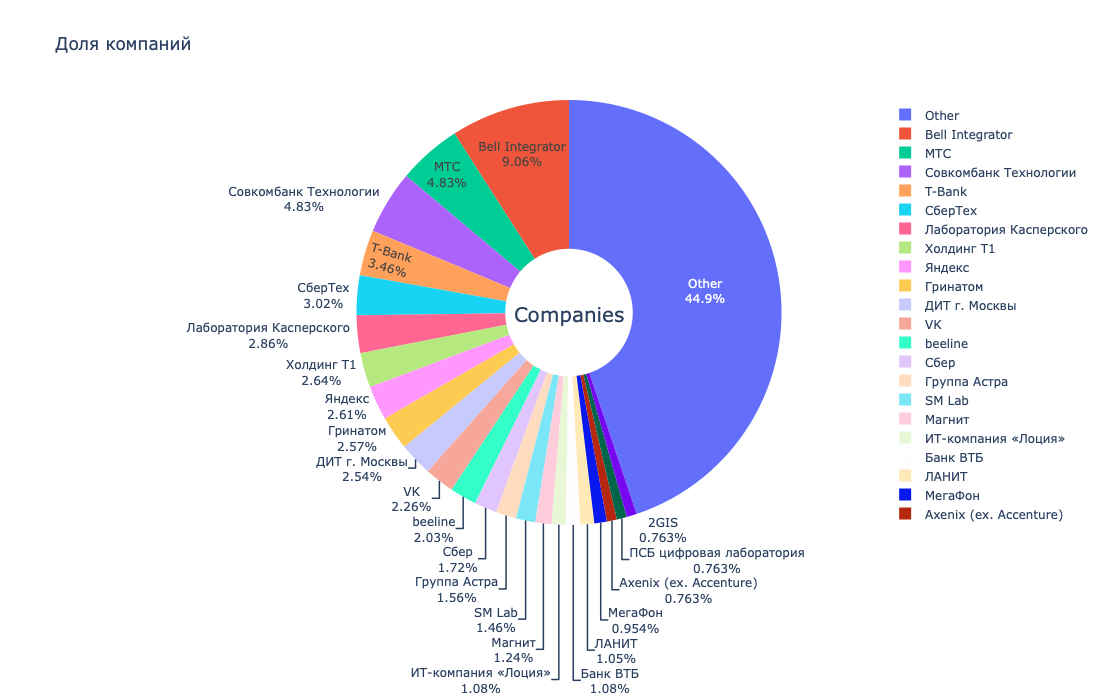

In [10]:
company_share = df['company'].value_counts(normalize=True) * 100
other_companies = company_share[company_share < 0.6]
other_share = other_companies.sum()
company_share = company_share.drop(other_companies.index)
company_share['Other'] = other_share


fig = go.Figure(data=[go.Pie(labels=company_share.index, values=company_share, textinfo='percent+label', hole=.3)])
fig.update_layout(
    title_text='Доля компаний',
    annotations=[dict(text='Companies', x=0.5, y=0.5, font_size=20, showarrow=False)],
    width=1000, 
    height=700
)
fig.show()


Посмотрим, на средние нижние и верхние границы зарплат среди компаний, разместивших 3 и более вакансий

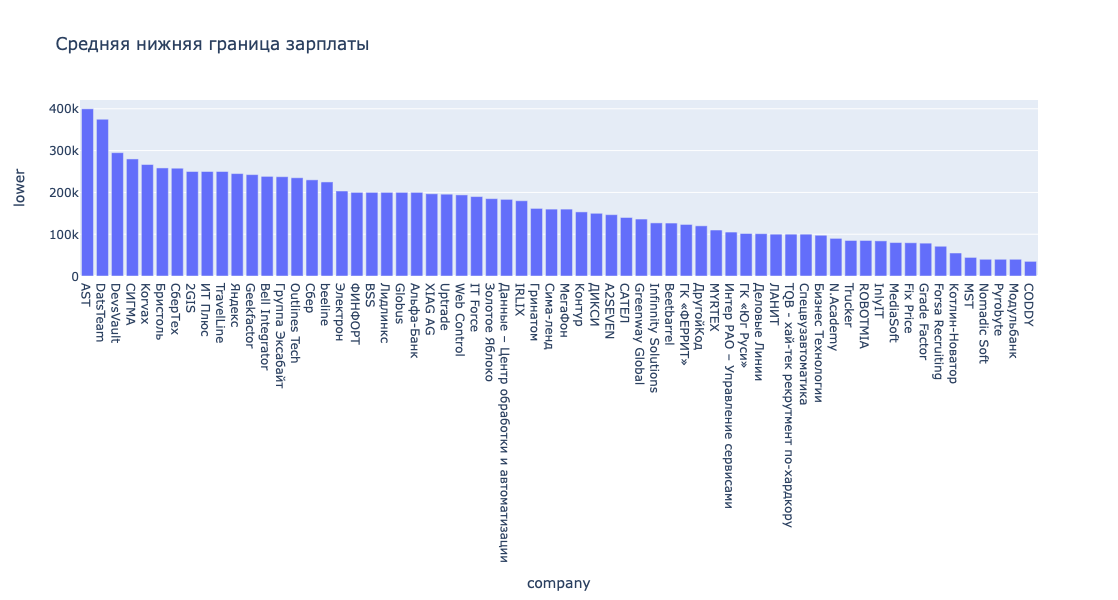

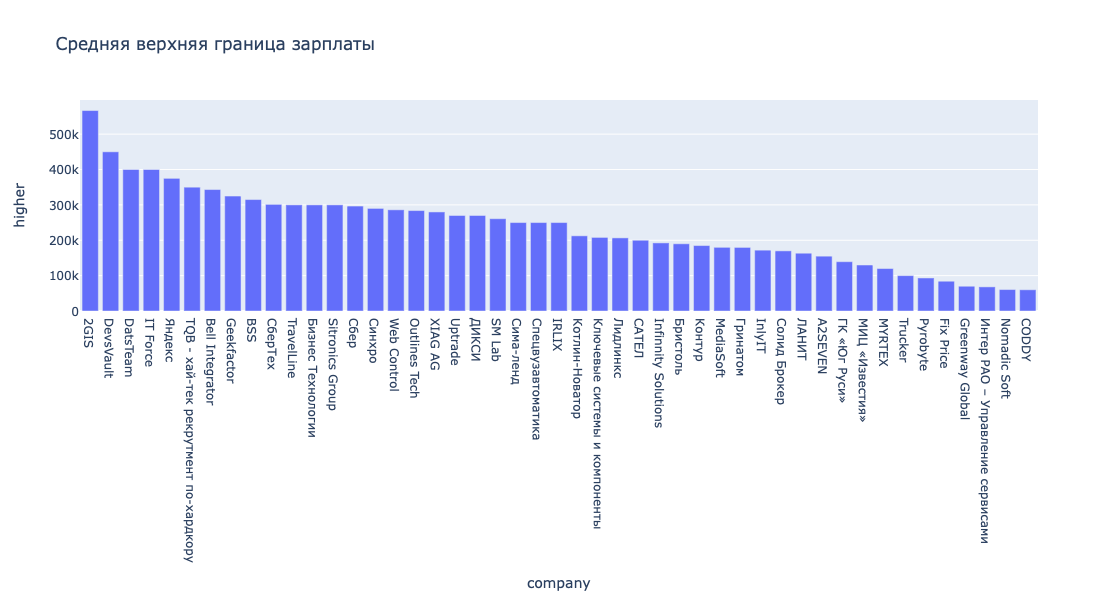

In [11]:
company_counts = df_ml['company'].value_counts()
filtered_companies = company_counts[company_counts >= 3].index
averages_filtered = df_ml[df_ml['company'].isin(filtered_companies)].groupby('company')[['lower', 'higher']].mean().reset_index()
averages_filtered_lower = averages_filtered.dropna(subset=['lower']).sort_values(by='lower', ascending=False)
averages_filtered_higher = averages_filtered.dropna(subset=['higher']).sort_values(by='higher', ascending=False)
fig_lower = px.bar(averages_filtered_lower, x='company', y='lower', title='Средняя нижняя граница зарплаты')
fig_lower.update_layout(width=800, height=600)
fig_lower.show()
fig_higher = px.bar(averages_filtered_higher, x='company', y='higher', title='Средняя верхняя граница зарплаты')
fig_higher.update_layout(width=800, height=600)
fig_higher.show()


Кажется логичным, что чем выше грейд, тем выше должна быть и заработная плата. Проверим эту гипотезу

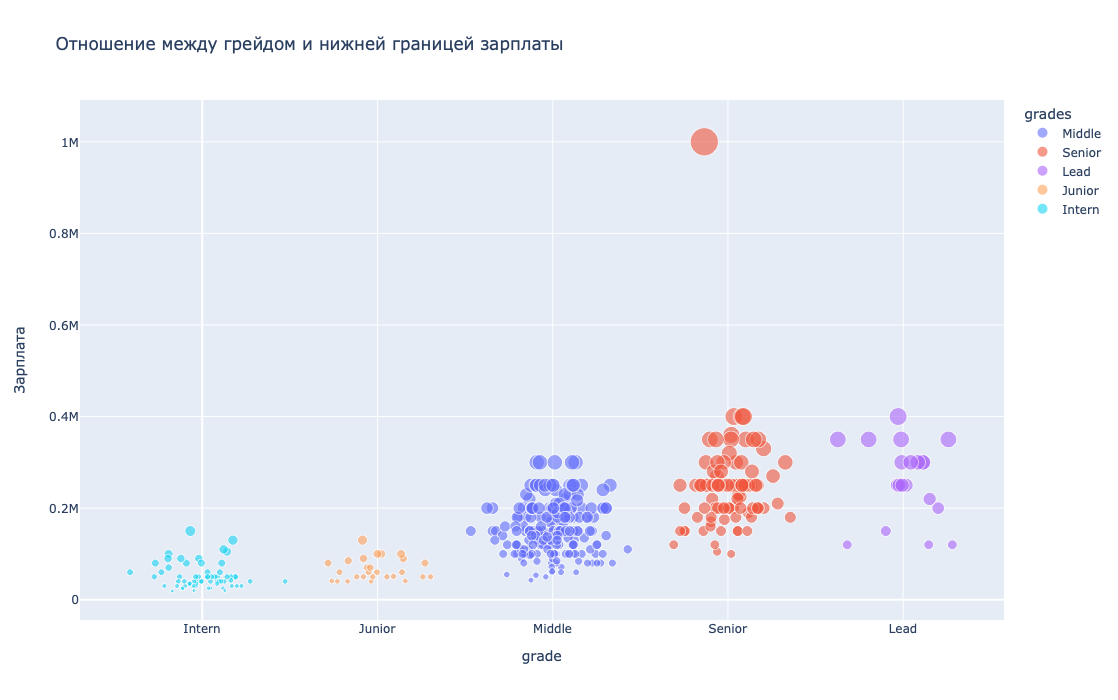

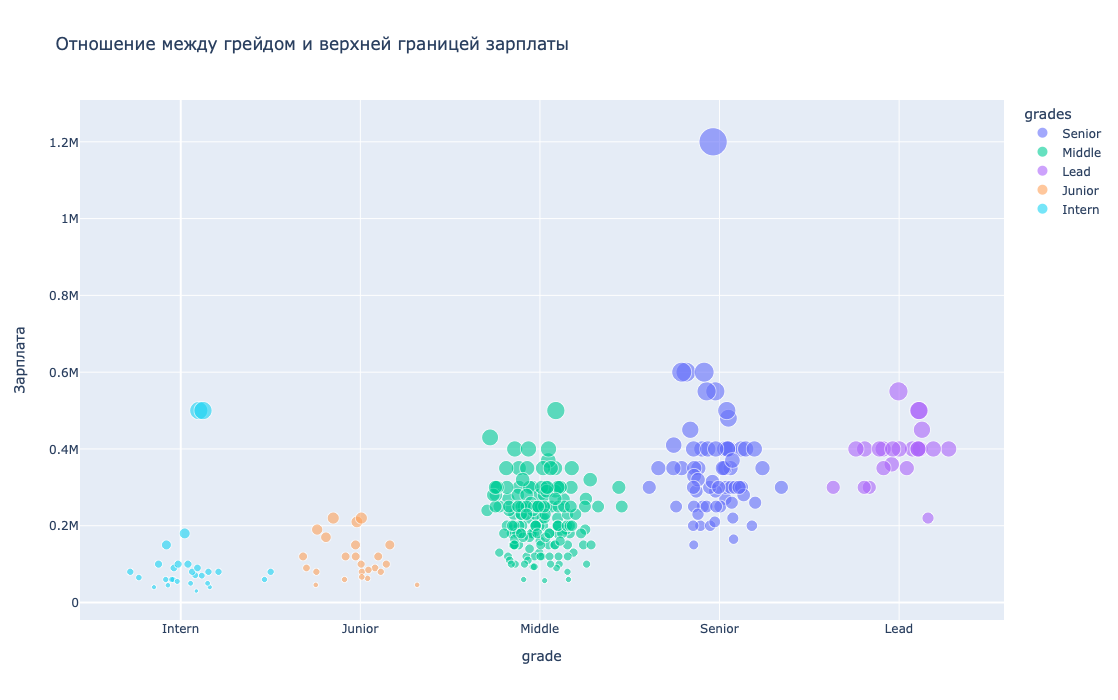

In [12]:
df_ml_lower = df_ml.dropna(subset=['lower']).copy()
df_ml_higher = df_ml.dropna(subset=['higher']).copy()


grade_order = ['Intern', 'Junior', 'Middle', 'Senior', 'Lead']
df_ml_lower['grades'] = pd.Categorical(df_ml_lower['grade'], categories=grade_order, ordered=True)
df_ml_lower['grade_code'] = df_ml_lower['grades'].cat.codes
df_ml_lower['grade'] = df_ml_lower['grade_code'] + np.random.normal(0, 0.15, df_ml_lower.shape[0]) #добавим немного шума по горизонтали, чтобы точки не накладывались друг на друга
grade_mapping_lower = dict(enumerate(df_ml_lower['grades'].cat.categories))


df_ml_higher['grades'] = pd.Categorical(df_ml_higher['grade'], categories=grade_order, ordered=True)
df_ml_higher['grade_code'] = df_ml_higher['grades'].cat.codes
df_ml_higher['grade'] = df_ml_higher['grade_code'] + np.random.normal(0, 0.15, df_ml_higher.shape[0])
grade_mapping_higher = dict(enumerate(df_ml_higher['grades'].cat.categories))


fig_lower_grade = px.scatter(df_ml_lower, x='grade', y='lower', color='grades', 
                             title='Отношение между грейдом и нижней границей зарплаты', 
                             labels={'lower': 'Зарплата'},
                             size='lower', hover_data=['company'], opacity=0.6)
fig_lower_grade.update_layout(xaxis=dict(tickmode='array', tickvals=list(grade_mapping_lower.keys()), ticktext=list(grade_mapping_lower.values())), width=1000, height=700)
fig_higher_grade = px.scatter(df_ml_higher, x='grade', y='higher', color='grades', 
                              title='Отношение между грейдом и верхней границей зарплаты', 
                              labels={'higher': 'Зарплата'},
                              size='higher', hover_data=['company'], opacity=0.6)
fig_higher_grade.update_layout(xaxis=dict(tickmode='array', tickvals=list(grade_mapping_higher.keys()), ticktext=list(grade_mapping_higher.values())), width=1000, height=700)


fig_lower_grade.show()
fig_higher_grade.show()


Из диаграммы выше становится очевидно, что мы столкнемся с selection bias. Для того, чтобы проверить, как распределены вакансии с условием на частично открытые зарплаты по отношению к безусловному распределению, воспользуемся SQL *(ну очень хочется + балл за это)*

In [13]:
conn = sqlite3.connect(':memory:')
df_sql = df_ml.copy(deep = True)
df_sql = df_sql.drop('skills', axis = 1)
df_sql = df_sql.drop('city', axis = 1)
df_sql.to_sql('df_ml', conn, index=False, if_exists='replace')


def run_query(query):
    return pd.read_sql_query(query, conn) #элегантно определим функцию

#достанем распред по грейдам
query1 = """
SELECT grade, COUNT(*) as count
FROM df_ml
GROUP BY grade
"""
#достанем распред по грейдам с условием на зп
query2 = """
SELECT grade, COUNT(*) as count
FROM df_ml
WHERE lower IS NOT NULL OR higher IS NOT NULL
GROUP BY grade
"""

df_grade_distribution = pd.read_sql_query(query1, conn)
df_conditional_grade_distribution = pd.read_sql_query(query2, conn)

conn.close()

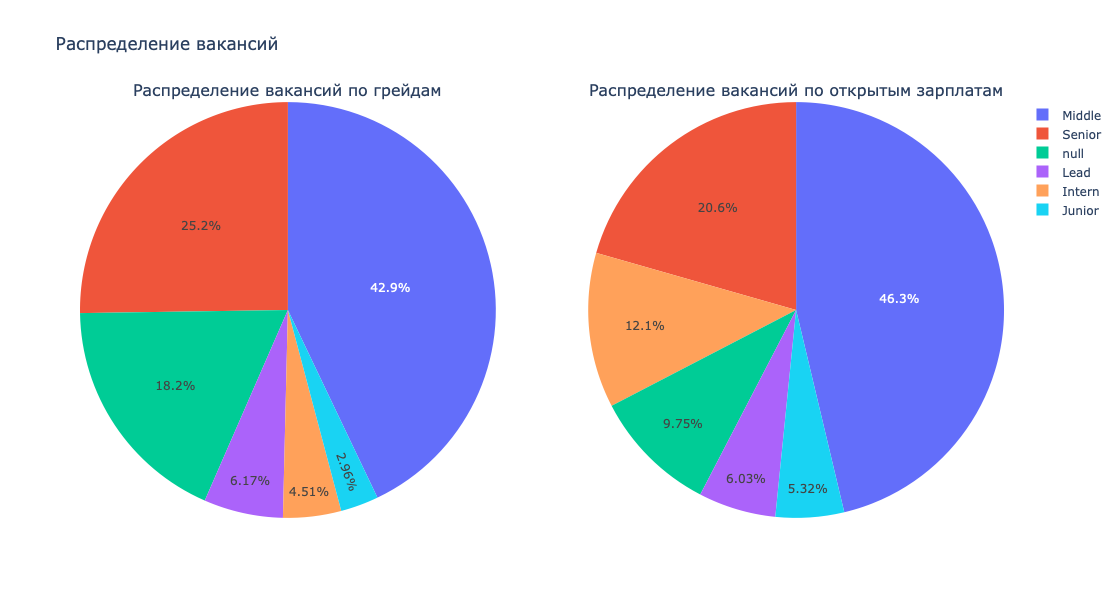

In [14]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Распределение вакансий по грейдам', 'Распределение вакансий по открытым зарплатам'])
fig.add_trace(go.Pie(labels=df_grade_distribution['grade'], values=df_grade_distribution['count'], name="Grades"),
              row=1, col=1)
fig.add_trace(go.Pie(labels=df_conditional_grade_distribution['grade'], values=df_conditional_grade_distribution['count'], name="Conditioned Grades"),
              row=1, col=2)
fig.update_layout(title_text='Распределение вакансий', height=600, width=1000)
fig.show()

Заметим, что вакансий для старших грейдов сильно больше, чем вакансий для младших грейдов. Видим также, что условие на наличие данных о зарплате сильно смещает распределение

Кажется логичным, что нижняя и верхняя границы зарплатной вилки должны быть положительно скоррелированы. Проверим это

In [15]:
df_ml_clean = df_ml.dropna(subset=['lower', 'higher'])
lower_salaries = df_ml_clean['lower'].to_numpy()
higher_salaries = df_ml_clean['higher'].to_numpy()
correlation = np.corrcoef(lower_salaries, higher_salaries)[0, 1]

print(f"Корреляция между нижней и верхней границами вилки: {correlation:.2f}")

Корреляция между нижней и верхней границами вилки: 0.87


Проверим, что разница в нижних границах зарплат для джуниоров и синиоров является статистически значимой

In [16]:
df_ml_clean = df_ml.dropna(subset=['lower'])
junior_salaries = df_ml_clean[df_ml_clean['grade'] == 'Junior']['lower']
senior_salaries = df_ml_clean[df_ml_clean['grade'] == 'Senior']['lower']
t_stat, p_value = stats.ttest_ind(junior_salaries, senior_salaries, nan_policy='omit')
print(f"T-статистика: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.01:
    print("Разница в нижних границах зарплат для джуниоров и синиоров является статистически значимой.")
else:
    print("Разница в нижних границах зарплат для джуниоров и синиоров не является статистически значимой.")


T-статистика: -8.67, P-value: 0.0000
Разница в нижних границах зарплат для джуниоров и синиоров является статистически значимой.


In [17]:
df_ml_clean = df_ml.dropna(subset=['lower'])
junior_salaries = df_ml_clean[df_ml_clean['grade'] == 'Lead']['lower']
senior_salaries = df_ml_clean[df_ml_clean['grade'] == 'Senior']['lower']
t_stat, p_value = stats.ttest_ind(junior_salaries, senior_salaries, nan_policy='omit')
print(f"T-статистика: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.01:
    print("Разница в нижних границах зарплат для лидов и синиоров является статистически значимой.")
else:
    print("Разница в нижних границах зарплат для лидов и синиоров не является статистически значимой.")


T-статистика: 0.65, P-value: 0.5159
Разница в нижних границах зарплат для лидов и синиоров не является статистически значимой.


Интересно, что для лидов и синиоров гипотеза о значимости различий в нижней границе вилок отвергается

Посмотрим теперь на распределение вакансий по миру

In [18]:
city_counts = df_ml['city'].explode().value_counts() #достанем города из списков
geolocator = Nominatim(user_agent="heatmap_app")
coordinates = {}
for city in city_counts.keys():
    location = geolocator.geocode(city)
    if location:
        coordinates[city] = (location.latitude, location.longitude) #добавим координаты городов
map_heatmap = folium.Map(location=[55.755825, 37.617298], zoom_start=2)


max_vacancies = city_counts.max()
for city, count in city_counts.items():
    if city in coordinates:
        folium.CircleMarker(
            location=coordinates[city],
            radius=np.sqrt(count), #радиус будет зависеть от числа вакансий
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(map_heatmap)
map_heatmap


Предсказуемо, бОльшая часть вакансий связана с Москвой, Санкт-Петербургом и другими крупными Российскими городами, хотя в целом позиции разбросаны по всему миру

Посмотрим на то, как часто самые популярные скиллы (встречающиеся не менее 100 раз) связаны между собой. Построим граф, ребра которого будут тем толще, чем чаще мы видим эти скиллы вместе на одну позицию

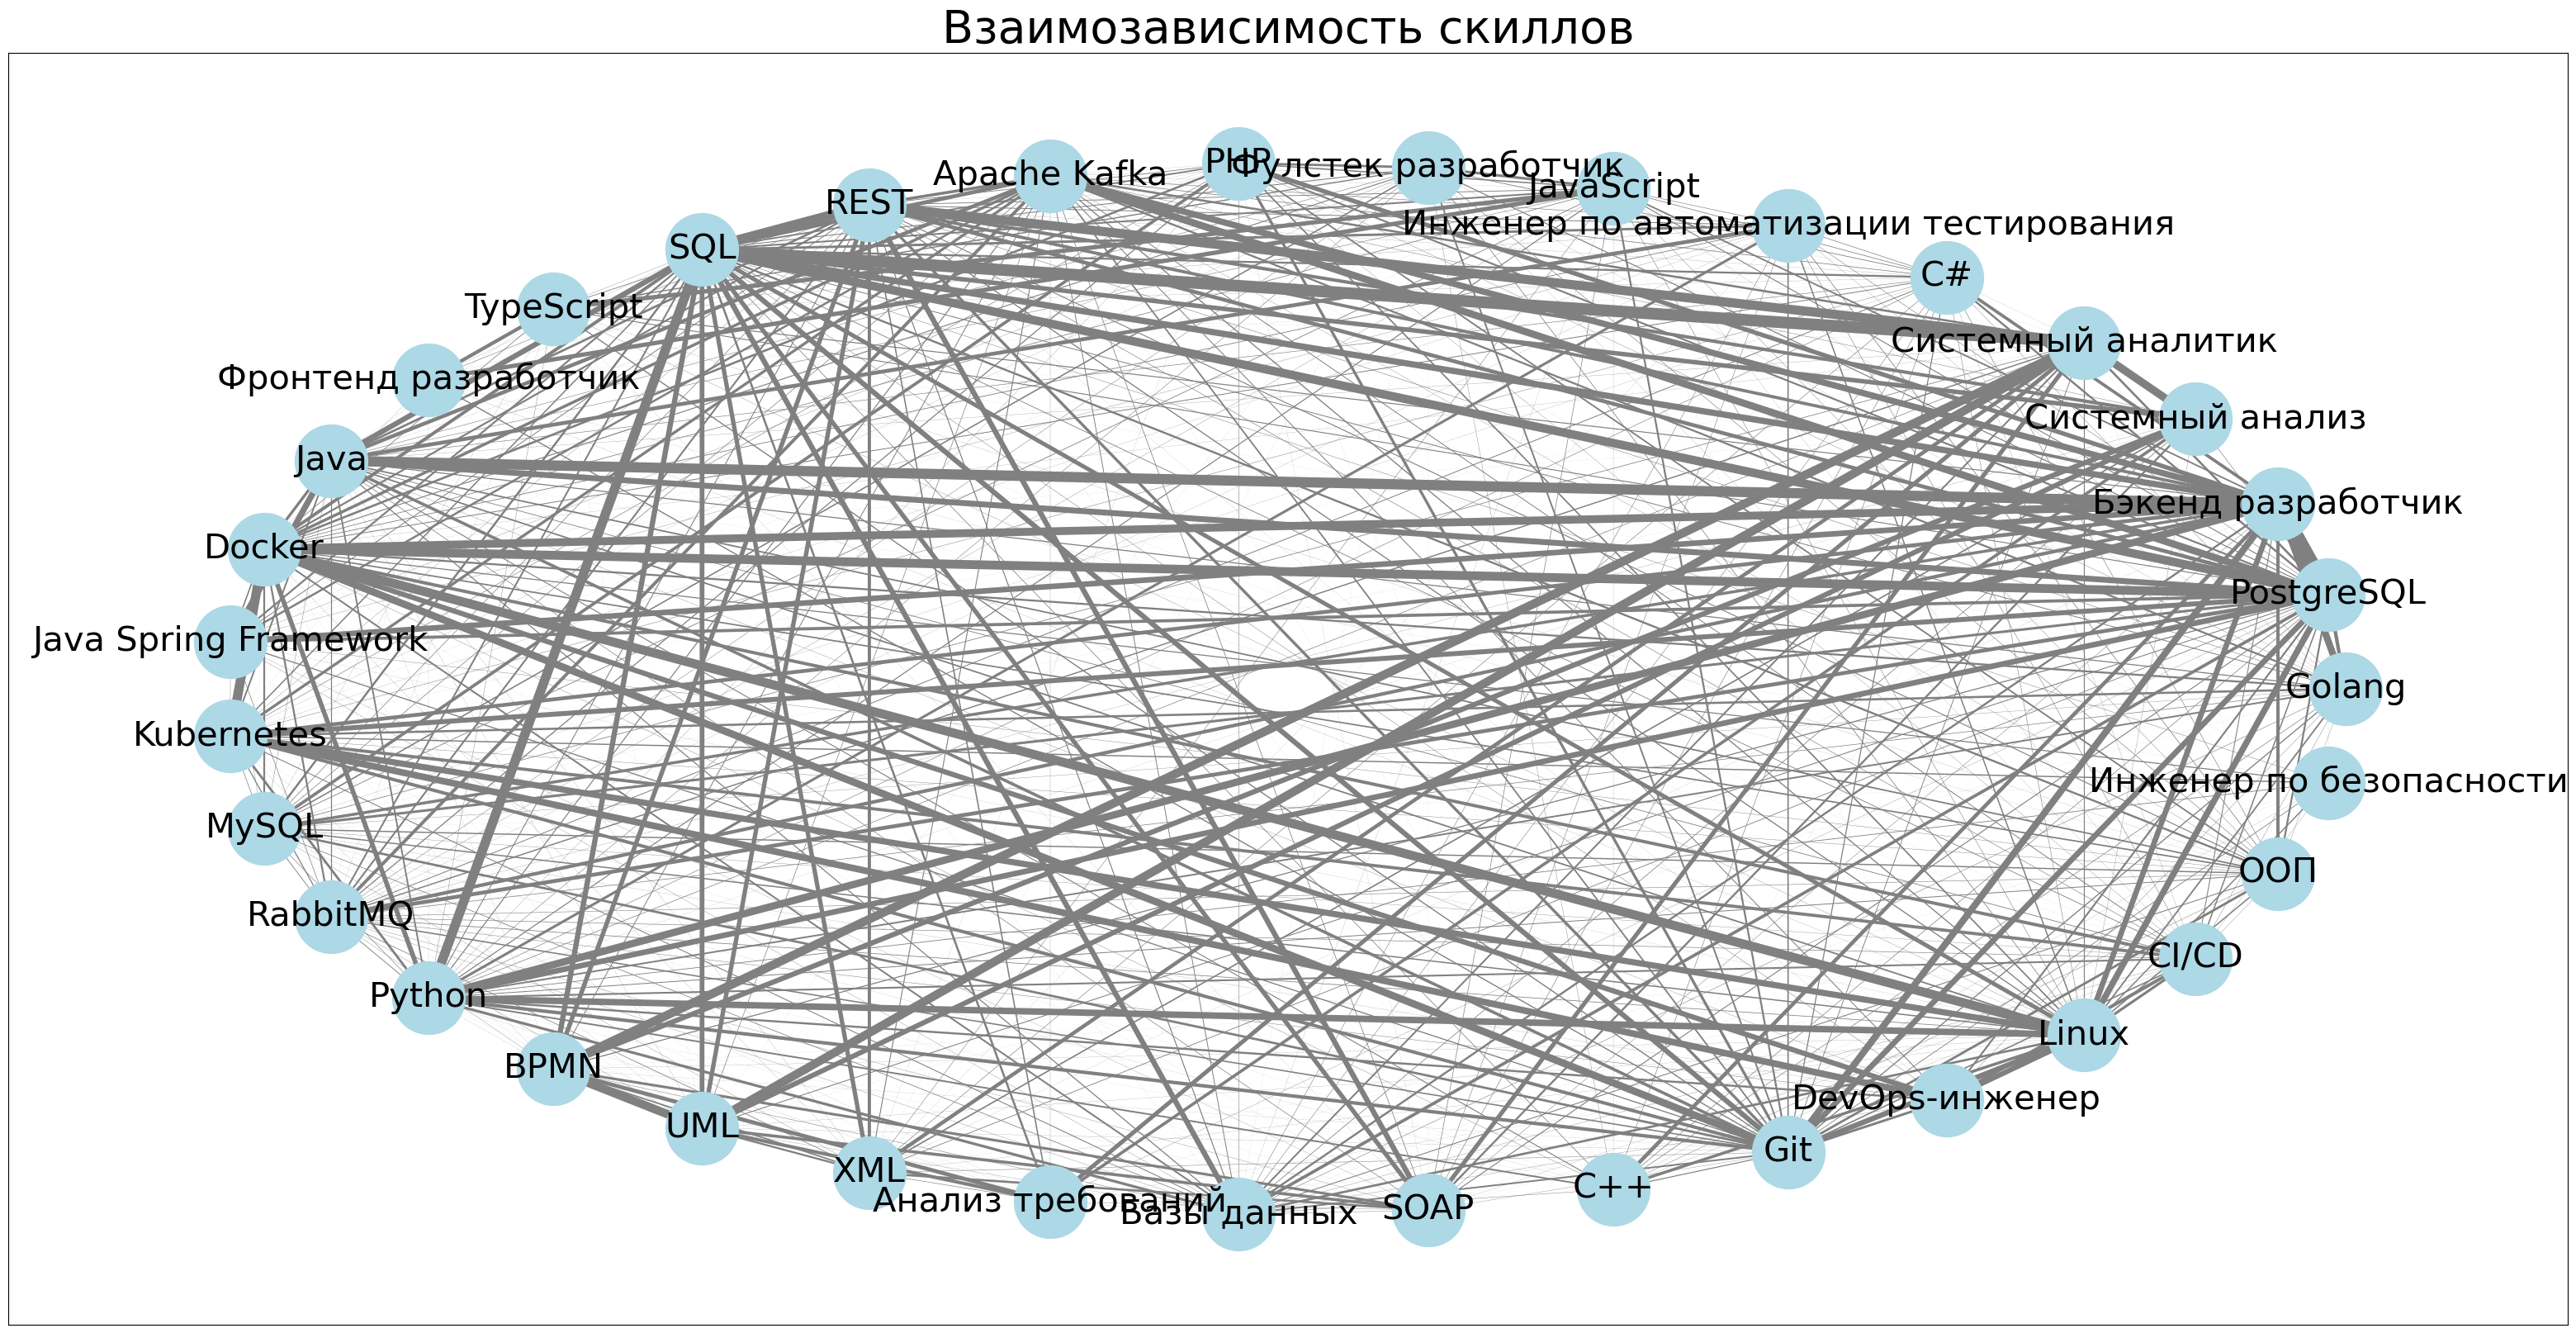

Самые взаимозависимые скиллы:
PostgreSQL - Бэкенд разработчик: 266
SQL - Системный аналитик: 205
Java - Бэкенд разработчик: 178
REST - SQL: 173
Python - SQL: 165
Docker - Kubernetes: 163
REST - Системный аналитик: 160
Docker - Linux: 157
Docker - PostgreSQL: 154
BPMN - Системный аналитик: 151
BPMN - UML: 148
UML - Системный аналитик: 148
PostgreSQL - SQL: 148
Docker - Бэкенд разработчик: 138
Системный анализ - Системный аналитик: 137


In [19]:
all_skills = [skill for sublist in df_ml['skills'] for skill in sublist]
skill_counts = Counter(all_skills)
filtered_skills = {skill for skill, count in skill_counts.items() if count >= 100} #возьмем только скиллы, встречающиеся хотя бы 100 раз
pairs = []
for skills in df_ml['skills']:
    filtered_skills_in_list = [skill for skill in skills if skill in filtered_skills]
    pairs.extend(combinations(sorted(filtered_skills_in_list), 2)) #добавляем пару
pair_counts = Counter(pairs)
G = nx.Graph()

for (skill1, skill2), weight in pair_counts.items():
    G.add_edge(skill1, skill2, weight=weight)
plt.figure(figsize=(40, 20)) 
pos = nx.circular_layout(G)
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='lightblue')
nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    width=[data['weight'] / 20 for i, i, data in edges],
    edge_color='gray'
)
nx.draw_networkx_labels(
    G, pos, 
    font_size=30, 
    font_family="sans-serif",
    font_color='black' 
)
plt.title("Взаимозависимость скиллов", fontdict =  {'fontsize': 40})
plt.show()


most_codependent_skills = pair_counts.most_common(15)
print("Самые взаимозависимые скиллы:")
for (skill1, skill2), count in most_codependent_skills:
    print(f"{skill1} - {skill2}: {count}")

Посчитаем теперь метрики центральности в сети для всех скиллов

In [20]:
pairs = []
for skills in df_ml['skills']:
    pairs.extend(combinations(sorted(skills), 2))
pair_counts = Counter(pairs)
G = nx.Graph()
for (skill1, skill2), weight in pair_counts.items():
    G.add_edge(skill1, skill2, weight=weight)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

def print_top_skills(centrality_dict, centrality_name, top_n=10): #определим аккуратненькую функцию для вывода топ-n скиллов по центральности
    sorted_skills = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    print(f"Топ {top_n} скиллов по {centrality_name}:")
    for skill, centrality in sorted_skills:
        print(f"{skill}: {centrality:.4f}")
    print()

print_top_skills(degree_centrality, "degree centrality")
print_top_skills(betweenness_centrality, "betweenness centrality")
print_top_skills(closeness_centrality, "closeness centrality")
print_top_skills(eigenvector_centrality, "eigenvector centrality")


Топ 10 скиллов по degree centrality:
SQL: 0.4398
Linux: 0.3924
Git: 0.3738
PostgreSQL: 0.3646
Python: 0.3646
Бэкенд разработчик: 0.2882
Docker: 0.2789
Java: 0.2535
REST: 0.2303
JavaScript: 0.2292

Топ 10 скиллов по betweenness centrality:
SQL: 0.1216
Linux: 0.0824
Python: 0.0812
Git: 0.0637
PostgreSQL: 0.0530
Английский язык: 0.0472
Бэкенд разработчик: 0.0385
Java: 0.0329
Figma Design: 0.0263
JavaScript: 0.0251

Топ 10 скиллов по closeness centrality:
SQL: 0.6273
Linux: 0.5935
Python: 0.5915
Git: 0.5907
PostgreSQL: 0.5890
Бэкенд разработчик: 0.5495
Docker: 0.5443
Java: 0.5429
Английский язык: 0.5409
JavaScript: 0.5405

Топ 10 скиллов по eigenvector centrality:
SQL: 0.1789
Git: 0.1677
Linux: 0.1670
PostgreSQL: 0.1667
Python: 0.1561
Docker: 0.1445
REST: 0.1366
Java: 0.1291
Базы данных: 0.1286
Бэкенд разработчик: 0.1278



Видим, что главными скиллами в сети (а значит, и на рынке) оказываются SQL, Git, Linux и Python.

# Немного наивного ML

Сразу стоит сказать, что у нас откровенно маловато данных для того, чтобы делать какие-либо серьезные предсказания. Но больше на Хабре вакансий просто нет :)) По-хорошему, надо умнее подходить к обработке признаков: аккуратно разметить похожие, не злоупотреблять One-Hot'ом для бустинга, поскрейпить другие сервисы (например, careerspace), где можно достать больше фичей из текстового описания вакансии, которого нет на Хабре. Здесь я всего лишь накидал простенький бейзлайн (и хочу + балл за оптуну 😁😁😁)

Подготовим данные: сделаем ванхот по скиллам, городам; лейбл энкодинг для времени работы, возможности удаленной работы. Выбросим строки, где отсутствует информация о грейде, дропнем названия вакансий, компаний и дату размещения

In [21]:
df_for_ml = df_ml.copy(deep = True)
df_for_ml['city'] = df_for_ml['city'].apply(lambda x: x if x is not None else [])
unique_skills = set(skill for sublist in df_for_ml['skills'] for skill in sublist)
unique_cities = set(city for sublist in df_for_ml['city'] for city in sublist)

for skill in unique_skills:
    df_for_ml[skill] = df_for_ml['skills'].apply(lambda x: int(skill in x))
for city in unique_cities:
    df_for_ml[city] = df_for_ml['city'].apply(lambda x: int(city in x))
    
unique_times = set(df_for_ml['time'])
unique_remote_work = set(df_for_ml['remote_work'])

df_for_ml['time'] = LabelEncoder().fit_transform(df_for_ml['time'])
df_for_ml['remote_work'] = LabelEncoder().fit_transform(df_for_ml['remote_work'])
grade_mapping = {grade_order[i]: i for i in range(len(grade_order))}
df_for_ml['grade'] = df_for_ml['grade'].map(grade_mapping)
df_for_ml.drop(columns=['skills', 'city', 'name', 'company', 'date'], inplace=True)

Подберем гиперпараметры, используя оптуну

In [22]:
# X = df_for_ml.dropna(subset=['lower', 'grade'])
# X.drop(columns=['lower', 'higher'], inplace=True)
# y = df_for_ml.dropna(subset=['lower', 'grade'])['lower']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# imputer = KNNImputer(n_neighbors = 2)
# X_train_imputed = imputer.fit_transform(X_train)
# X_val_imputed = imputer.transform(X_val)
# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 50),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 15),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0, 15),
#         'verbose' : -1
#     }
#     clf = LGBMRegressor(**params)
#     clf.fit(
#         X=X_train_imputed,
#         y=y_train
#     )
#     y_pred = clf.predict(X_val_imputed)
#     rmse = mean_squared_error(y_val, y_pred, squared=False)
#     return rmse
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

In [23]:
best_params = {'learning_rate': 0.0830404344160791,
 'num_leaves': 252,
 'max_depth': 5,
 'min_data_in_leaf': 1,
 'feature_fraction': 0.350965916481022,
 'bagging_fraction': 0.7992409340346522,
 'bagging_freq': 2,
 'lambda_l1': 0.6008610700780599,
 'lambda_l2': 1.2671936347441806, 
 'verbose' : -1}

In [24]:
X = df_for_ml.dropna(subset=['lower', 'grade'])
X.drop(columns=['lower', 'higher'], inplace=True)
y = df_for_ml.dropna(subset=['lower', 'grade'])['lower']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = KNNImputer(n_neighbors = 2)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train_imputed, y_train)
y_pred = model.predict(X_val_imputed)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Best RMSE: {rmse:.2f}")

Best RMSE: 47290.57


In [25]:
X.shape[0]

403

У нас всего 403 объекта, что, конечно, печально

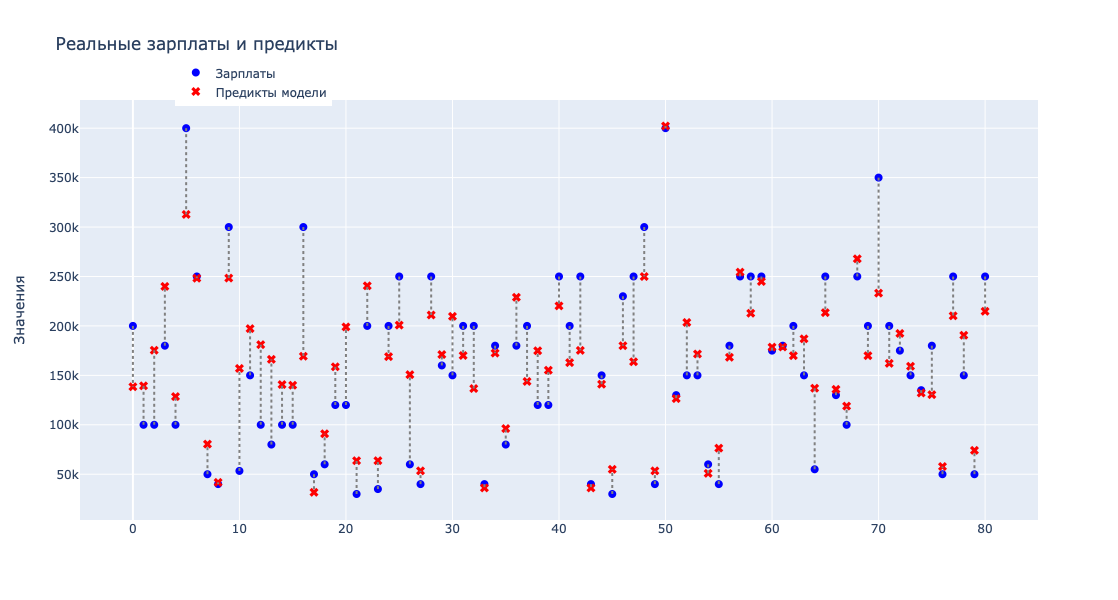

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(len(y_val))),
    y=y_val,
    mode='markers',
    marker=dict(color='blue', size=8, symbol='circle'),
    name='Зарплаты'
))
fig.add_trace(go.Scatter(
    x=list(range(len(y_val))),
    y=y_pred,
    mode='markers',
    marker=dict(color='red', size=8, symbol='x'),
    name='Предикты модели'
))
for i in range(len(y_val)):
    fig.add_trace(go.Scatter(
        x=[i, i],
        y=[y_val.iloc[i], y_pred[i]],
        mode='lines',
        line=dict(color='gray', dash='dot'),
        showlegend=False
    ))
fig.update_layout(
    title='Реальные зарплаты и предикты',
    yaxis_title='Значения',
    width=1000,
    height=600,
    legend=dict(
        x=0.1,
        y=1.1,
        traceorder='normal',
        font=dict(size=12),
    )
)
fig.show()


Результаты, конечно, так себе. Но нас это не пугает
Посмотрим на feature importance

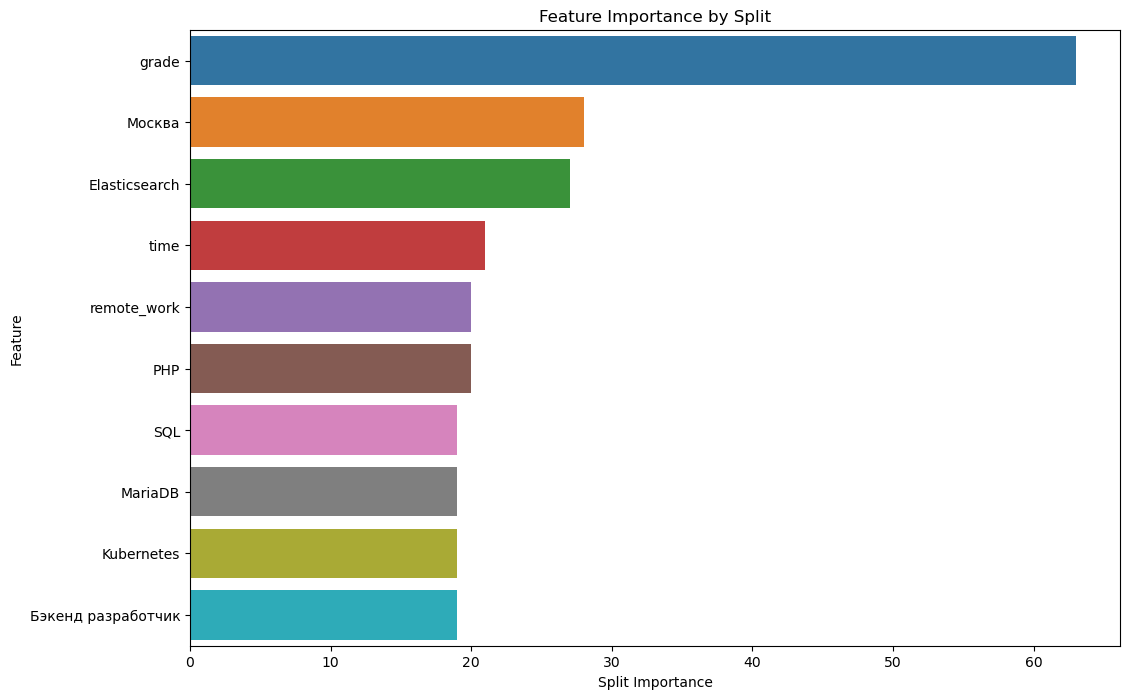

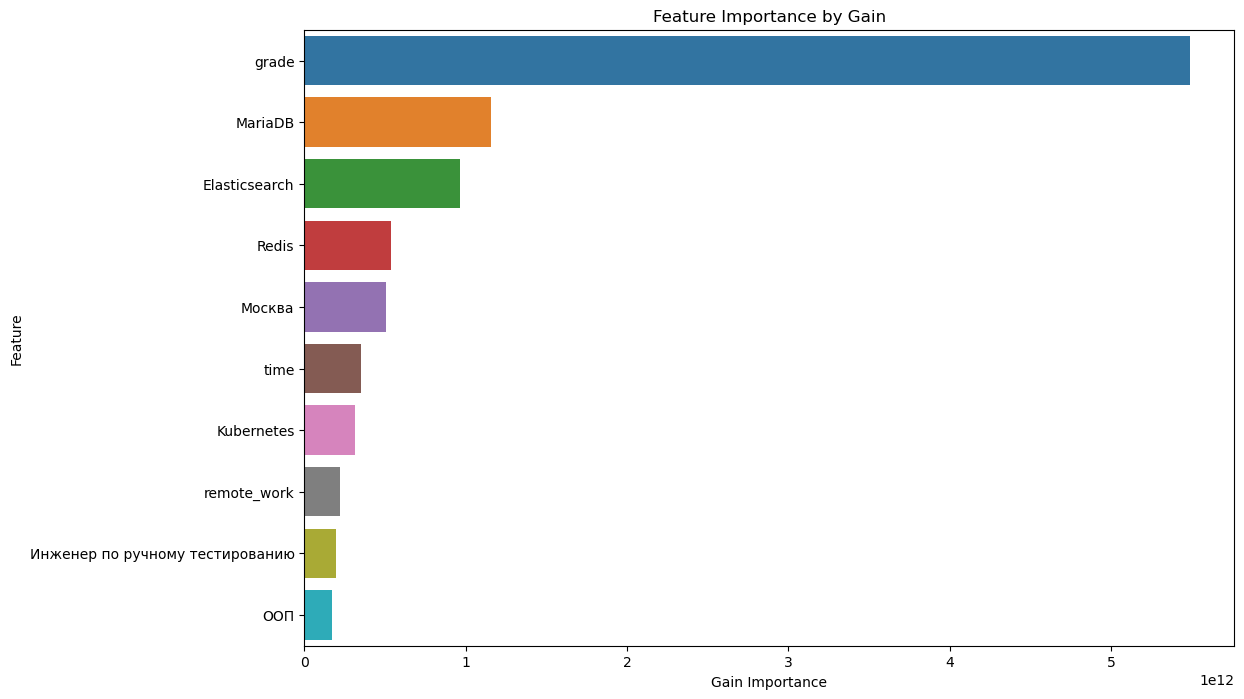

In [27]:
X = df_for_ml.dropna(subset=['lower', 'grade'])
X.drop(columns=['lower', 'higher'], inplace=True)
y = df_for_ml.dropna(subset=['lower', 'grade'])['lower']
split_importances = model.feature_importances_
gain_importances = model.booster_.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Split Importance': split_importances,
    'Gain Importance': gain_importances
})
sorted_importance_df_split = importance_df.sort_values(by='Split Importance', ascending=False)
sorted_importance_df_gain = importance_df.sort_values(by='Gain Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Split Importance', y='Feature', data=sorted_importance_df_split.head(10))
plt.title('Feature Importance by Split')
plt.xlabel('Split Importance')
plt.ylabel('Feature')
plt.show()
plt.figure(figsize=(12, 8))
sns.barplot(x='Gain Importance', y='Feature', data=sorted_importance_df_gain.head(10))
plt.title('Feature Importance by Gain')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.show()

Проделаем то же самое для верхней границы

In [28]:
# X = df_for_ml.dropna(subset=['higher', 'grade'])
# X.drop(columns=['lower', 'higher'], inplace=True)
# y = df_for_ml.dropna(subset=['higher', 'grade'])['higher']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# imputer = KNNImputer(n_neighbors = 2)
# X_train_imputed = imputer.fit_transform(X_train)
# X_val_imputed = imputer.transform(X_val)
# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 50),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 15),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0, 15),
#         'verbose' : -1
#     }
    
#     clf = LGBMRegressor(**params)
#     clf.fit(
#         X=X_train_imputed,
#         y=y_train
#     )
#     y_pred = clf.predict(X_val_imputed)
#     rmse = mean_squared_error(y_val, y_pred, squared=False)
#     return rmse
# study_2 = optuna.create_study(direction='minimize')
# study_2.optimize(objective, n_trials=500)

In [29]:
best_params_2 = {'learning_rate': 0.08762959909080413,
 'num_leaves': 261,
 'max_depth': 35,
 'min_data_in_leaf': 1,
 'feature_fraction': 0.8245320898607478,
 'bagging_fraction': 0.727327187030781,
 'bagging_freq': 10,
 'lambda_l1': 9.672653010547828,
 'lambda_l2': 14.420834110033585,
 'verbose' : -1}

In [30]:
X = df_for_ml.dropna(subset=['higher', 'grade'])
X.drop(columns=['lower', 'higher'], inplace=True)
y = df_for_ml.dropna(subset=['higher', 'grade'])['higher']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = KNNImputer(n_neighbors = 2)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
model_2 = lgb.LGBMRegressor(**best_params_2)
model_2.fit(X_train_imputed, y_train)
y_pred = model_2.predict(X_val_imputed)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Best RMSE: {rmse:.2f}")

Best RMSE: 71375.44


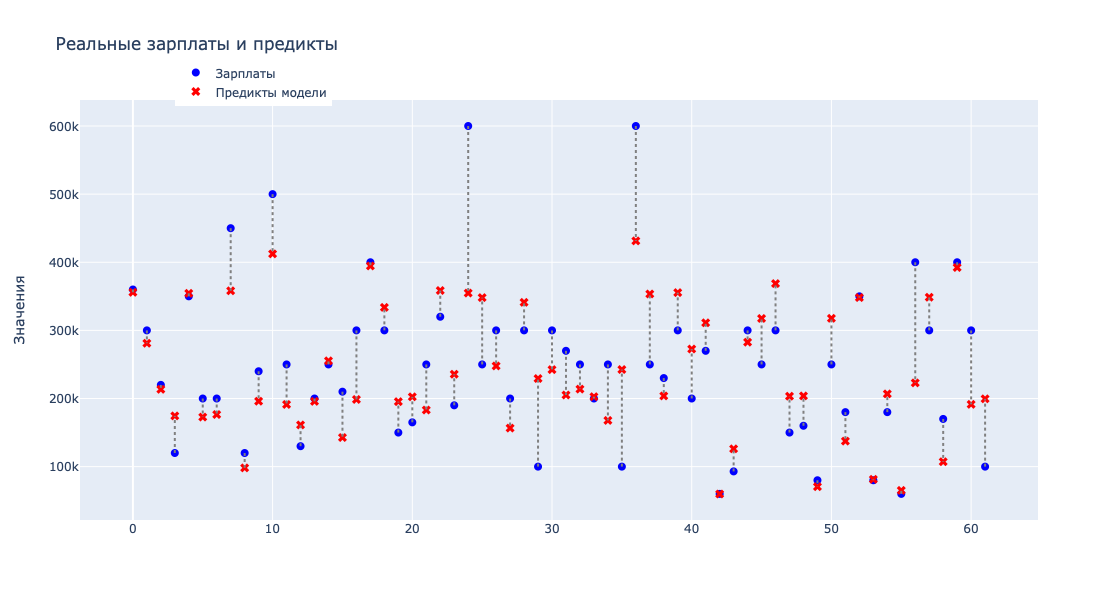

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(len(y_val))),
    y=y_val,
    mode='markers',
    marker=dict(color='blue', size=8, symbol='circle'),
    name='Зарплаты'
))
fig.add_trace(go.Scatter(
    x=list(range(len(y_val))),
    y=y_pred,
    mode='markers',
    marker=dict(color='red', size=8, symbol='x'),
    name='Предикты модели'
))
for i in range(len(y_val)):
    fig.add_trace(go.Scatter(
        x=[i, i],
        y=[y_val.iloc[i], y_pred[i]],
        mode='lines',
        line=dict(color='gray', dash='dot'),
        showlegend=False
    ))
fig.update_layout(
    title='Реальные зарплаты и предикты',
    yaxis_title='Значения',
    width=1000,
    height=600,
    legend=dict(
        x=0.1,
        y=1.1,
        traceorder='normal',
        font=dict(size=12),
    )
)
fig.show()


Тут все еще хуже. Ну, ладно

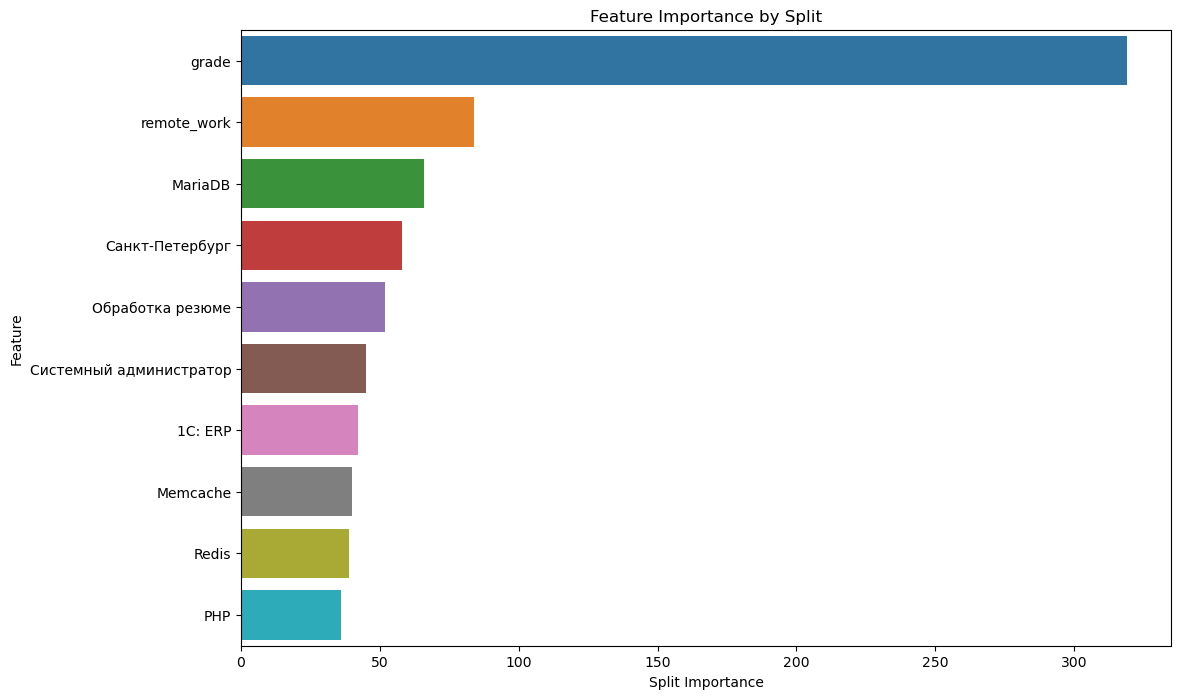

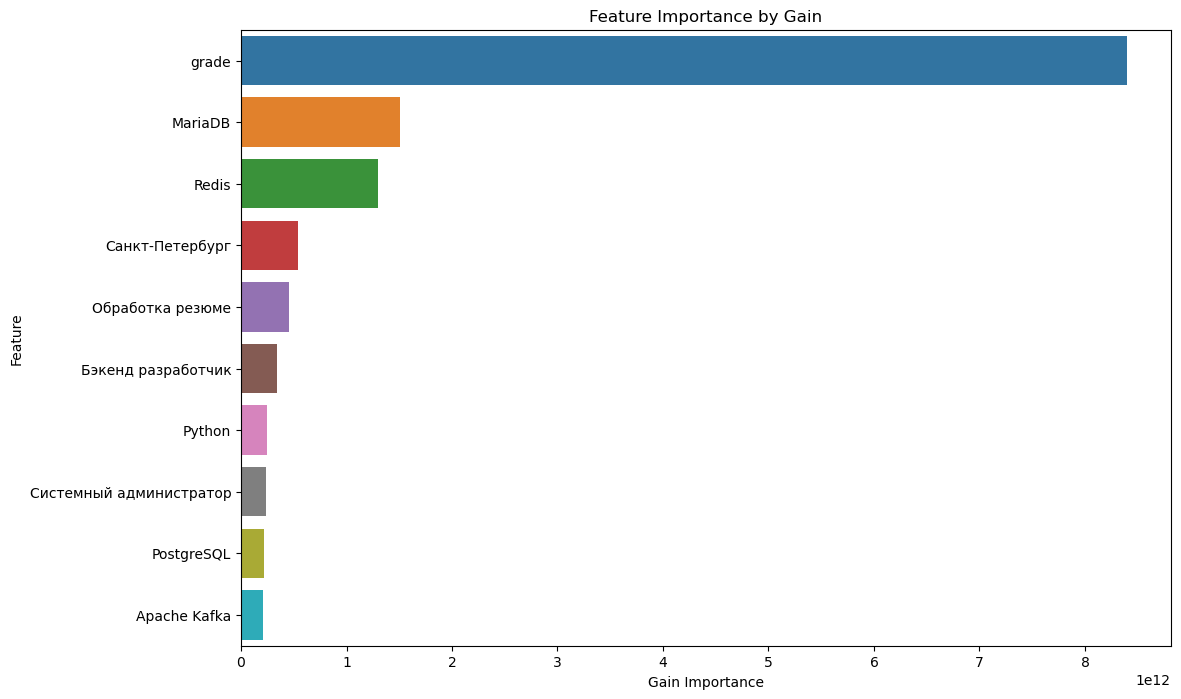

In [32]:
X = df_for_ml.dropna(subset=['higher', 'grade'])
X.drop(columns=['lower', 'higher'], inplace=True)
y = df_for_ml.dropna(subset=['higher', 'grade'])['higher']
split_importances = model_2.feature_importances_
gain_importances = model_2.booster_.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Split Importance': split_importances,
    'Gain Importance': gain_importances
})
sorted_importance_df_split = importance_df.sort_values(by='Split Importance', ascending=False)
sorted_importance_df_gain = importance_df.sort_values(by='Gain Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Split Importance', y='Feature', data=sorted_importance_df_split.head(10))
plt.title('Feature Importance by Split')
plt.xlabel('Split Importance')
plt.ylabel('Feature')
plt.show()
plt.figure(figsize=(12, 8))
sns.barplot(x='Gain Importance', y='Feature', data=sorted_importance_df_gain.head(10))
plt.title('Feature Importance by Gain')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.show()

Предсказуемо, главным признаком для обеих моделей является грейд.

# Итоги

1. Главным предиктором зарплаты специалиста является его грейд
2. На рынке ищут в основном синиоров, лидов и мидлов; вакансий для специалистов с грейдом ниже кратно меньше
3. Самыми востребованными скиллами на рынке являются владение SQL, Git, Linux и Python
4. Работодатели не любят публично делиться вилками зарплат (во всяком случае, на Хабре)
5. Зарплата растет при перемещении по грейдам до синиора; разница в зарплате у синиора и лида минимальна (но тут очевидно selection bias)
6. На Хабре в основном размещаются компании, базирующиеся в Москве